Here, we create a multiclass classifier for classifying the various closest vectors returned by the model, as the corresponding attributes.

In [511]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.text
from keras.models import load_model

import matplotlib.pyplot as plt
%matplotlib inline

## Prepare Dataset

Read the data

In [260]:
df = pd.read_csv('truthvalue_classifier.csv', encoding='utf8')

In [261]:
df.head()

,ProviderNumber,HospitalName,Address1,City,State,ZipCode,CountyName,PhoneNumber,HospitalType,HospitalOwner,EmergencyService,MeasureCode
0,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,SCIP-CARD-2
1,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,SCIP-INF-1
2,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,SCIP-INF-2
3,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,SCIP-INF-3
4,10018,CALLAHAN EYE FOUNDATION HOSPITAL,1720 UNIVERSITY BLVD,BIRMINGHAM,AL,35233,JEFFERSON,2053258100,Acute Care Hospitals,Voluntary non-profit - Private,Yes,SCIP-INF-4


In [262]:
len(df)

1000

In [267]:
df.columns.values

array(['ProviderNumber', 'HospitalName', 'Address1', 'City', 'State',
       'ZipCode', 'CountyName', 'PhoneNumber', 'HospitalType',
       'HospitalOwner', 'EmergencyService', 'MeasureCode'], dtype=object)

In [268]:
#hospital dataset

#1. load hospital dataset and turthvalue.csv; mark error for unmatched values and cleanup using FastText; fill empty cells with word2vec
#finding errors and outliers -> discover FDs and try marking errors? or word2vec most_similar of val and if row does not contain the cell values??!

df_hospital = pd.read_csv('dirty_data_transformed.csv', dtype=object)
df_truth = pd.read_csv('truthvalue.csv', dtype=object)

provider = df_truth['ProviderNumber'].tolist()
hospital = df_truth['HospitalName'].tolist()
address = df_truth['Address1'].tolist()
city = df_truth['City'].tolist()
state = df_truth['State'].tolist()
zipcode = df_truth['ZipCode'].tolist()
county = df_truth['CountyName'].tolist()
phone = df_truth['PhoneNumber'].tolist()
hospType = df_truth['HospitalType'].tolist()
owner = df_truth['HospitalOwner'].tolist()
service = df_truth['EmergencyService'].tolist()
code = df_truth['MeasureCode'].tolist()

combined_hosp = list(zip(provider, hospital, address, city, state, zipcode, county, phone, hospType, owner, service, code))


In [271]:
values = [provider, hospital, address, city, state, zipcode, county, phone, hospType, owner, service, code]
attributes = ['Provider', 'Hospital', 'Address', 'City', 'State', 'Zipcode', 'County', 'Phone', 'hospType', 'Owner', 'Service', 'Code']

Create value, attribute-name tuple pairs

In [272]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([value, attributes[i]])

In [273]:
len(data)

12000

In [274]:
data[:10]

[['10018', 'Provider'],
 ['10018', 'Provider'],
 ['10018', 'Provider'],
 ['10018', 'Provider'],
 ['10018', 'Provider'],
 ['10018', 'Provider'],
 ['10018', 'Provider'],
 ['10018', 'Provider'],
 ['10019', 'Provider'],
 ['10019', 'Provider']]

In [275]:
data[-10:]

[['HF-4', 'Code'],
 ['PN-2', 'Code'],
 ['PN-3B', 'Code'],
 ['PN-4', 'Code'],
 ['PN-5C', 'Code'],
 ['PN-6', 'Code'],
 ['PN-7', 'Code'],
 ['SCIP-CARD-2', 'Code'],
 ['SCIP-INF-1', 'Code'],
 ['SCIP-INF-2', 'Code']]

In [276]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [277]:
dfData.head()

,Value,Label
0,10018,Provider
1,10018,Provider
2,10018,Provider
3,10018,Provider
4,10018,Provider


In [278]:
dfData.tail()

,Value,Label
11995,PN-6,Code
11996,PN-7,Code
11997,SCIP-CARD-2,Code
11998,SCIP-INF-1,Code
11999,SCIP-INF-2,Code


Convert labels to categorical attributes

In [279]:
dfData['Label'] = dfData['Label'].astype('category')

In [280]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [281]:
dfData.tail()

,Value,Label,Label_Cat
11995,PN-6,Code,2
11996,PN-7,Code,2
11997,SCIP-CARD-2,Code,2
11998,SCIP-INF-1,Code,2
11999,SCIP-INF-2,Code,2


In [282]:
dfData['Label_Cat'].value_counts()

7     1000
6     1000
5     1000
4     1000
11    1000
3     1000
10    1000
2     1000
9     1000
1     1000
8     1000
0     1000
Name: Label_Cat, dtype: int64

Get the mapping

In [283]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [284]:
mapping

{0: 'Address',
 1: 'City',
 2: 'Code',
 3: 'County',
 4: 'Hospital',
 5: 'Owner',
 6: 'Phone',
 7: 'Provider',
 8: 'Service',
 9: 'State',
 10: 'Zipcode',
 11: 'hospType'}

Drop the Label column

In [285]:
dfData.drop(['Label'], axis=1, inplace=True)

In [286]:
dfData.head()

,Value,Label_Cat
0,10018,7
1,10018,7
2,10018,7
3,10018,7
4,10018,7


Shuffle the data

In [287]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [288]:
dfData.head(10)

,Value,Label_Cat
0,Acute Care Hospitals,11
1,Voluntary non-profit - Private,5
2,10005,7
3,4800 48TH ST,0
4,JEFFERSON,3
5,301 EAST 18TH ST,0
6,SOUTHEAST ALABAMA MEDICAL CENTER,4
7,Voluntary non-profit - Church,5
8,AL,9
9,36106,10


Find the longest string in the value column

In [289]:
dfData.Value.map(lambda x: len(x)).max()

43

In [290]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

## Tokenize and obtain the train, test split

In [1014]:
batchSize = 20
maxSequenceLength = 100
maxWords = 300

In [1015]:
tokenizer = Tokenizer(num_words=maxWords)

In [1047]:
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
word_index

{'1': 29,
 '1000': 278,
 '10001': 259,
 '10005': 123,
 '10006': 147,
 '10007': 163,
 '10008': 208,
 '10009': 202,
 '10010': 187,
 '10011': 197,
 '10012': 205,
 '10015': 211,
 '10016': 274,
 '10018': 181,
 '10019': 134,
 '10021': 137,
 '10022': 241,
 '10023': 317,
 '10024': 305,
 '10025': 185,
 '10027': 262,
 '10029': 164,
 '10032': 156,
 '10033': 270,
 '10034': 312,
 '10035': 280,
 '10036': 206,
 '10038': 107,
 '10039': 111,
 '10040': 175,
 '10043': 297,
 '10044': 264,
 '10045': 299,
 '10046': 109,
 '10047': 170,
 '10049': 180,
 '10050': 328,
 '10055': 351,
 '10056': 359,
 '1007': 290,
 '10085': 385,
 '10086': 238,
 '10087': 352,
 '101': 57,
 '1010': 191,
 '10108': 324,
 '10158': 369,
 '10164': 345,
 '1108': 222,
 '1201': 381,
 '124': 319,
 '1256': 243,
 '126': 139,
 '1300': 141,
 '150': 329,
 '15155': 379,
 '1530': 276,
 '157': 268,
 '1653': 232,
 '1720': 209,
 '1725': 217,
 '18th': 101,
 '1912': 267,
 '19th': 149,
 '2': 17,
 '200': 265,
 '2000': 294,
 '20017': 332,
 '20018': 365,
 '2

In [1017]:
print('Found %s unique tokens.' % len(word_index))

Found 386 unique tokens.


In [1018]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)
data

array([[  0,   0,   0, ...,   1,   2,   3],
       [  0,   0,   0, ...,  10,  11,  16],
       [  0,   0,   0, ...,   0,   0, 123],
       ..., 
       [  0,   0,   0, ...,   0,   0,  47],
       [  0,   0,   0, ...,   0,   0,   4],
       [  0,   0,   0, ...,   0,   0,   4]], dtype=int32)

In [1019]:
labels = np.asarray(y)

In [1020]:
data.shape

(12000, 100)

In [1021]:
labels.shape

(12000,)

In [1022]:
labels = to_categorical(labels)

In [1023]:
labels.shape

(12000, 12)

Shuffle the dataset

In [1024]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)

In [1025]:
data = data[indices]
labels = labels[indices]

Train test split

In [1026]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [1027]:
len(X_train), len(y_train)

(9600, 9600)

In [1028]:
len(X_test), len(y_test)

(2400, 2400)

## Model

In [1029]:
embeddingDim = 80

**Architecture**
* 1 embedding layer 
* 1 dense layer, 32 hidden units and _relu_ activation
* 1 dense layer, 64 hidden units and _relu_ activation
* Output layer, _softmax_ activation

In [1030]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(12, activation=activations.softmax))

model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [1031]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_36 (Embedding)     (None, 100, 80)           24000     
_________________________________________________________________
flatten_36 (Flatten)         (None, 8000)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 32)                256032    
_________________________________________________________________
dense_107 (Dense)            (None, 64)                2112      
_________________________________________________________________
dense_108 (Dense)            (None, 12)                780       
Total params: 282,924
Trainable params: 282,924
Non-trainable params: 0
_________________________________________________________________


In [1032]:
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=batchSize, 
                    validation_split=0.2)

Train on 7680 samples, validate on 1920 samples
Epoch 1/10
7680/7680 [==============================] - 6s 753us/step - loss: 1.4767 - acc: 0.5284 - val_loss: 0.6395 - val_acc: 0.7083
Epoch 2/10
7680/7680 [==============================] - 4s 468us/step - loss: 0.3542 - acc: 0.9010 - val_loss: 0.2474 - val_acc: 0.9307
Epoch 3/10
7680/7680 [==============================] - 4s 469us/step - loss: 0.1540 - acc: 0.9424 - val_loss: 0.1432 - val_acc: 0.9380
Epoch 4/10
7680/7680 [==============================] - 4s 471us/step - loss: 0.1288 - acc: 0.9480 - val_loss: 0.1302 - val_acc: 0.9380
Epoch 5/10
7680/7680 [==============================] - 4s 472us/step - loss: 0.1242 - acc: 0.9447 - val_loss: 0.1283 - val_acc: 0.9406
Epoch 6/10
7680/7680 [==============================] - 4s 532us/step - loss: 0.1204 - acc: 0.9497 - val_loss: 0.1159 - val_acc: 0.9495
Epoch 7/10
7680/7680 [==============================] - 4s 477us/step - loss: 0.1184 - acc: 0.9475 - val_loss: 0.1199 - val_acc: 0.9495


In [1033]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

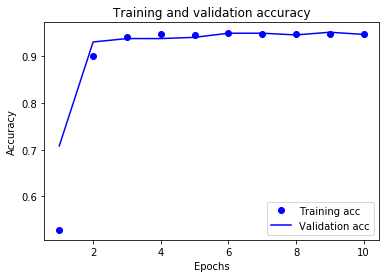

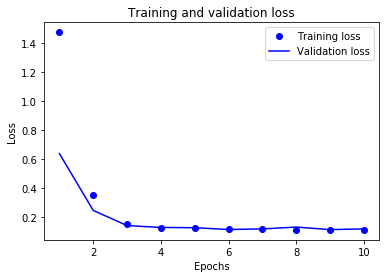

In [1034]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

Test on testing set

In [1035]:
results = model.evaluate(X_test, y_test)

2400/2400 [==============================] - 0s 112us/step


In [1036]:
loss = results[0]
accuracy = results[1]

In [1037]:
loss

0.1233886859950754

In [1038]:
accuracy

0.94416666666666671

** Test Set Accuracy: 98.67% **

Save the model

In [1039]:
model.save("HospitalClassifier.h5")

Save the tokenizer

In [1040]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

## Make predictions on new data

In [1041]:
model = load_model('HospitalClassifier.h5')

In [1042]:
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [1048]:
testString = ["Houston"]

In [1049]:
sequences = tokenizer.texts_to_sequences(testString)
testData = pad_sequences(sequences, maxlen=maxSequenceLength)

In [1050]:
predictions = model.predict(testData)

Amazon - {0: 'Author', 1: 'Format', 2: 'Name', 3: 'Publisher', 4: 'Publishing Date'}

In [1051]:
mapping[np.argmax(predictions[0])]

'County'